In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deep_learning/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deep_learning/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wro

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

labels = np.array(mnist.targets)

num_samples_per_class = 1000
selected_indices = []

# Iterar sobre cada clase (0-9)
for digit in range(10):
    indices = np.where(labels == digit)[0]  # Obtener índices del dígito
    selected_indices.extend(np.random.choice(indices, num_samples_per_class, replace=False))  # Selección aleatoria

balanced_subset = Subset(mnist, selected_indices)

train_loader = DataLoader(balanced_subset, batch_size=128, shuffle=True)

from collections import Counter
subset_labels = [mnist.targets[i].item() for i in selected_indices]
print("Distribución de clases en el subset:", Counter(subset_labels))

Distribución de clases en el subset: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})


In [3]:
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

labels_test = np.array(test_dataset.targets)

num_samples_per_class_test = 2500 // 10
selected_indices_test = []

for digit in range(10):
    indices = np.where(labels_test == digit)[0]
    selected_indices_test.extend(np.random.choice(indices, num_samples_per_class_test, replace=False))

balanced_subset_test = Subset(test_dataset, selected_indices_test)

test_loader = DataLoader(balanced_subset_test, batch_size=128, shuffle=True)

subset_labels_test = [test_dataset.targets[i].item() for i in selected_indices_test]
print(Counter(subset_labels_test))

Counter({0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250, 7: 250, 8: 250, 9: 250})


In [4]:
def plot_rbm_weights(rbm, figsize=(12, 12)):
    """Visualiza los pesos de una RBM en forma de imágenes, incluso si no son cuadradas."""
    weights = rbm.W.cpu().detach().numpy()  # Shape: (n_hidden, n_visible)
    n_hidden, n_visible = weights.shape

    # Intentamos encontrar una forma rectangular cercana
    possible_shapes = [(i, n_visible // i) for i in range(1, n_visible + 1) if n_visible % i == 0]
    best_shape = min(possible_shapes, key=lambda x: abs(x[0] - x[1]))  # La más cercana a un cuadrado

    print(f"Visualizando pesos como {best_shape[0]}x{best_shape[1]}")

    # Determinar la mejor disposición de la cuadrícula
    grid_size = int(np.ceil(np.sqrt(n_hidden)))  # Número de filas y columnas

    plt.figure(figsize=figsize)
    for i in range(n_hidden):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(weights[i].reshape(best_shape), cmap="gray")  # Ajustamos los pesos a la mejor forma posible
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reconstructions(rbm, data_loader, device, num_examples=10):
    """Visualiza reconstrucciones de una RBM para cualquier tamaño de entrada."""
    for batch, _ in data_loader:
        batch = batch.view(batch.size(0), -1).to(device)  # Aplanamos
        batch = (batch > 0.5).float()  # Binarizamos

        # Generar reconstrucciones
        v_prob, v_sampled = rbm.sample_v(rbm.sample_h(batch)[1])
        v_sampled = v_sampled.cpu().detach().numpy()
        batch = batch.cpu().detach().numpy()

        # Limitar al número de ejemplos solicitados
        n = min(num_examples, batch.shape[0])

        # Determinar la mejor forma de visualización para cada dato
        n_visible = batch.shape[1]
        side = int(np.sqrt(n_visible))  # Intentamos hacer una forma cuadrada
        
        if side * side != n_visible:  # Si no es cuadrado perfecto, buscamos una forma rectangular
            possible_shapes = [(i, n_visible // i) for i in range(1, n_visible + 1) if n_visible % i == 0]
            best_shape = min(possible_shapes, key=lambda x: abs(x[0] - x[1]))  # Más cercana a un cuadrado
        else:
            best_shape = (side, side)

        print(f"Visualizando reconstrucciones en forma de {best_shape[0]}x{best_shape[1]}")

        # Crear figura con subplots (2 filas, n columnas)
        fig, axes = plt.subplots(2, n, figsize=(n*2.5, 5))

        for i in range(n):
            # Mostrar imagen original
            axes[0, i].imshow(batch[i].reshape(best_shape))
            axes[0, i].set_title("Original")
            axes[0, i].axis("off")

            # Mostrar reconstrucción
            axes[1, i].imshow(v_sampled[i].reshape(best_shape))
            axes[1, i].set_title("Reconstrucción")
            axes[1, i].axis("off")

        plt.tight_layout()
        plt.show()
        break  # Solo el primer batch


In [6]:
def save_rbm_weights(rbm, path='rbm_weights.pt'):
    # Guarda solo la matriz de pesos
    torch.save({
        'W': rbm.W,
        'v_bias': rbm.v_bias,
        'h_bias': rbm.h_bias
    }, path)

# Para cargar después:
def load_rbm_weights(rbm, path='rbm_weights.pt'):
    weights = torch.load(path)
    rbm.W.data = weights['W']
    rbm.v_bias.data = weights['v_bias']
    rbm.h_bias.data = weights['h_bias']

In [7]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, device):
        super(RBM, self).__init__()
        self.device = device
        # Pesos y bias
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible, device=self.device) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(n_visible, device=self.device))
        self.h_bias = nn.Parameter(torch.zeros(n_hidden, device=self.device))

    def sample_h(self, v):
        # Calcula probabilidades de neuronas ocultas
        # h_prob = sigmoid(Wv + b)
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        # Calcula probabilidades de neuronas visibles
        # v_prob = sigmoid(Wh + c)
        v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return v_prob, torch.bernoulli(v_prob)

    def forward(self, v):
        # Para forward, devolvemos probabilidades y muestras de h
        h_prob, h_sample = self.sample_h(v)
        return h_prob, h_sample

    def energy(self, v, h):
        w_term = -torch.sum(torch.matmul(v, self.W.t()) * h, dim=1)
        v_term = -torch.matmul(v, self.v_bias)
        h_term = -torch.matmul(h, self.h_bias)
        return w_term + v_term + h_term

    def contrastive_divergence(self, v, k=1):
        # Un paso de Gibbs (CD-k)
        pos_h_prob, pos_h_sample = self.sample_h(v)

        h_prob, h_sample = pos_h_prob, pos_h_sample
        # Realizamos k pasos de muestreo (normalmente k = 1)
        for _ in range(k):
            v_prob, v_sample = self.sample_v(h_sample)
            h_prob, h_sample = self.sample_h(v_sample)

        # Actualizamos pesos (W, v_bias, h_bias)
        positive_grad = torch.matmul(v.t(), pos_h_prob)
        negative_grad = torch.matmul(v_prob.t(), h_prob)

        batch_size = v.size(0)
        self.W.grad = -(positive_grad - negative_grad).t() / batch_size
        self.v_bias.grad = -torch.mean(v - v_prob, dim=0)
        self.h_bias.grad = -torch.mean(pos_h_prob - h_prob, dim=0)

In [8]:
def train_rbm(rbm, data_loader, device, epochs=50, lr=0.01, k=1, binarize=True):
    optimizer = optim.SGD(rbm.parameters(), lr=lr)

    for epoch in range(epochs):
        num_batches = 0
        
        for batch, _ in data_loader:
            batch = batch.view(batch.size(0), -1).to(device)  # aplanamos (p. ej., MNIST 28x28 -> 784)
            if binarize:
                batch = (batch > 0.5).float()

            h_prob, h_sample = rbm.sample_h(batch)
            
            optimizer.zero_grad()
            rbm.contrastive_divergence(batch, k=k)
            optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] completado.")

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando GPU (Metal)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando GPU (Metal)


In [10]:
rbm = RBM(784, 128, device=device)

Visualizando pesos como 28x28


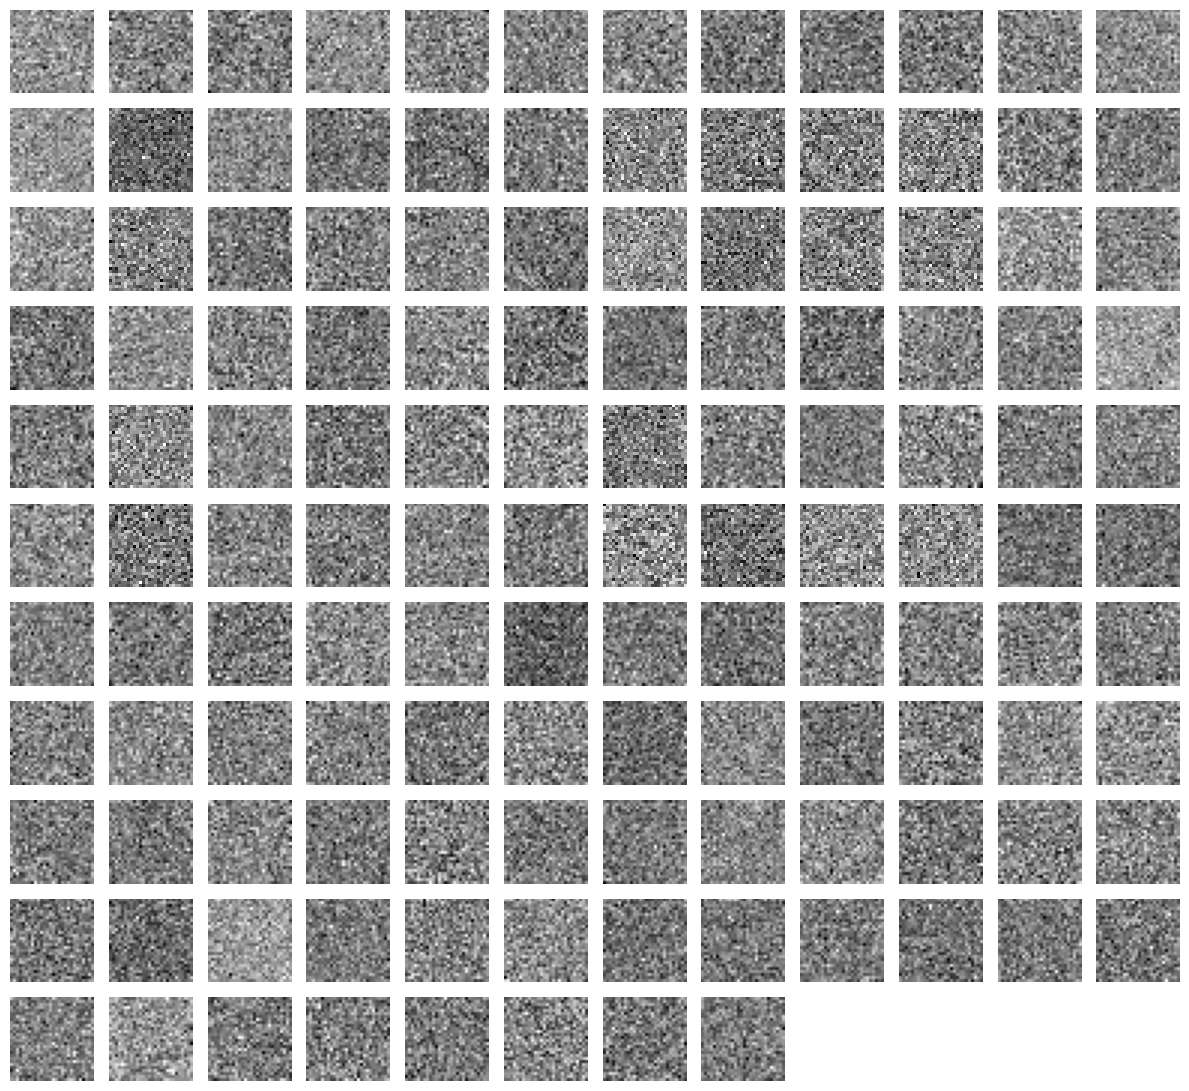

In [11]:
plot_rbm_weights(rbm)

In [12]:
train_rbm(rbm, train_loader, device, epochs=500, lr=0.005, k=1)

Epoch [1/500] completado.
Epoch [11/500] completado.
Epoch [21/500] completado.
Epoch [31/500] completado.
Epoch [41/500] completado.
Epoch [51/500] completado.
Epoch [61/500] completado.
Epoch [71/500] completado.
Epoch [81/500] completado.
Epoch [91/500] completado.
Epoch [101/500] completado.
Epoch [111/500] completado.
Epoch [121/500] completado.
Epoch [131/500] completado.
Epoch [141/500] completado.
Epoch [151/500] completado.
Epoch [161/500] completado.
Epoch [171/500] completado.
Epoch [181/500] completado.
Epoch [191/500] completado.
Epoch [201/500] completado.
Epoch [211/500] completado.
Epoch [221/500] completado.
Epoch [231/500] completado.
Epoch [241/500] completado.
Epoch [251/500] completado.
Epoch [261/500] completado.
Epoch [271/500] completado.
Epoch [281/500] completado.
Epoch [291/500] completado.
Epoch [301/500] completado.
Epoch [311/500] completado.
Epoch [321/500] completado.
Epoch [331/500] completado.
Epoch [341/500] completado.
Epoch [351/500] completado.
Epo

Visualizando pesos como 28x28


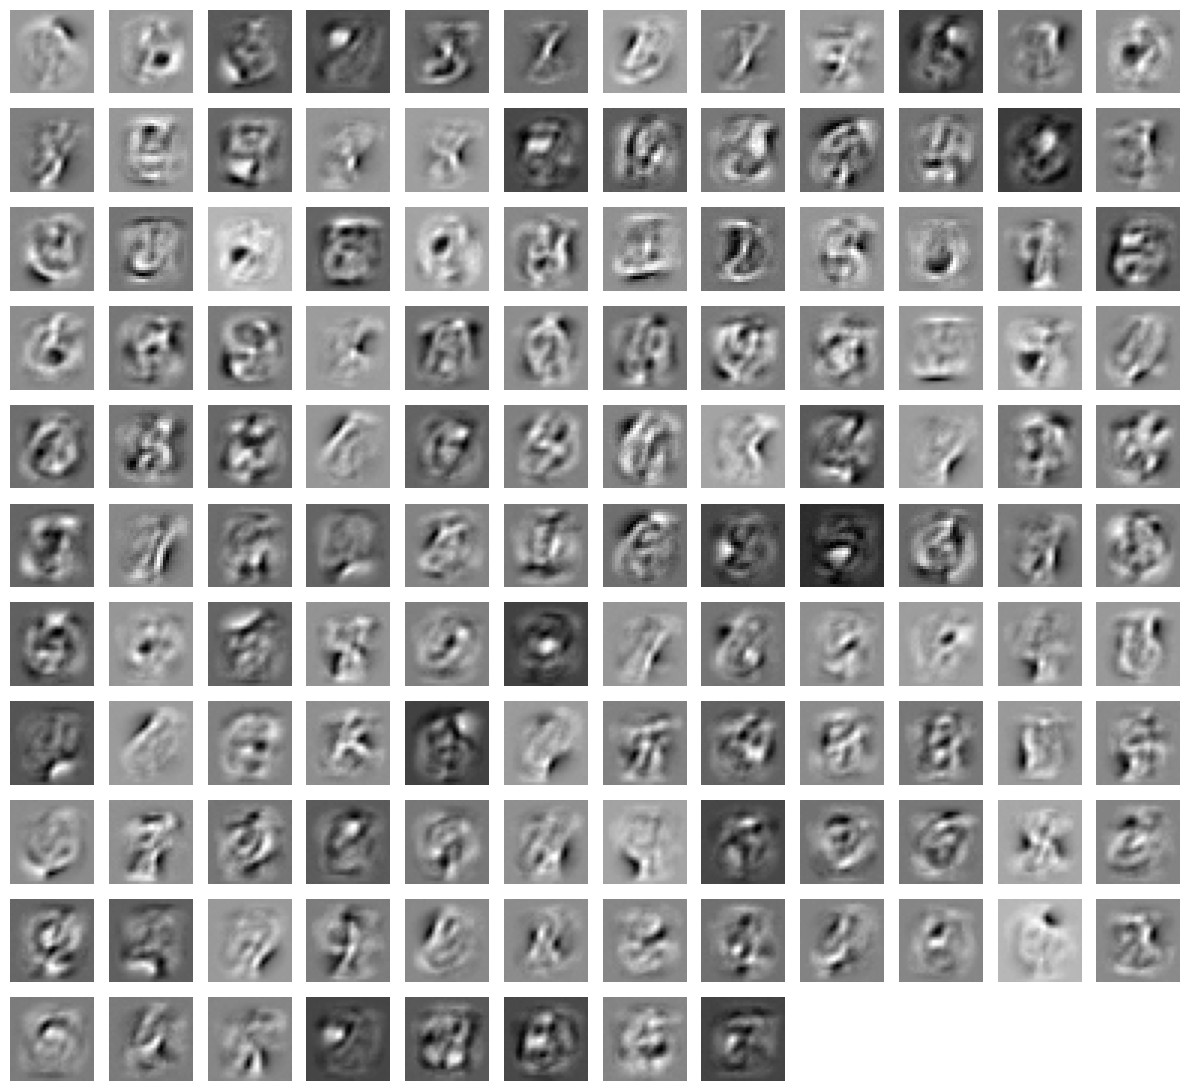

In [13]:
plot_rbm_weights(rbm)

Visualizando reconstrucciones en forma de 28x28


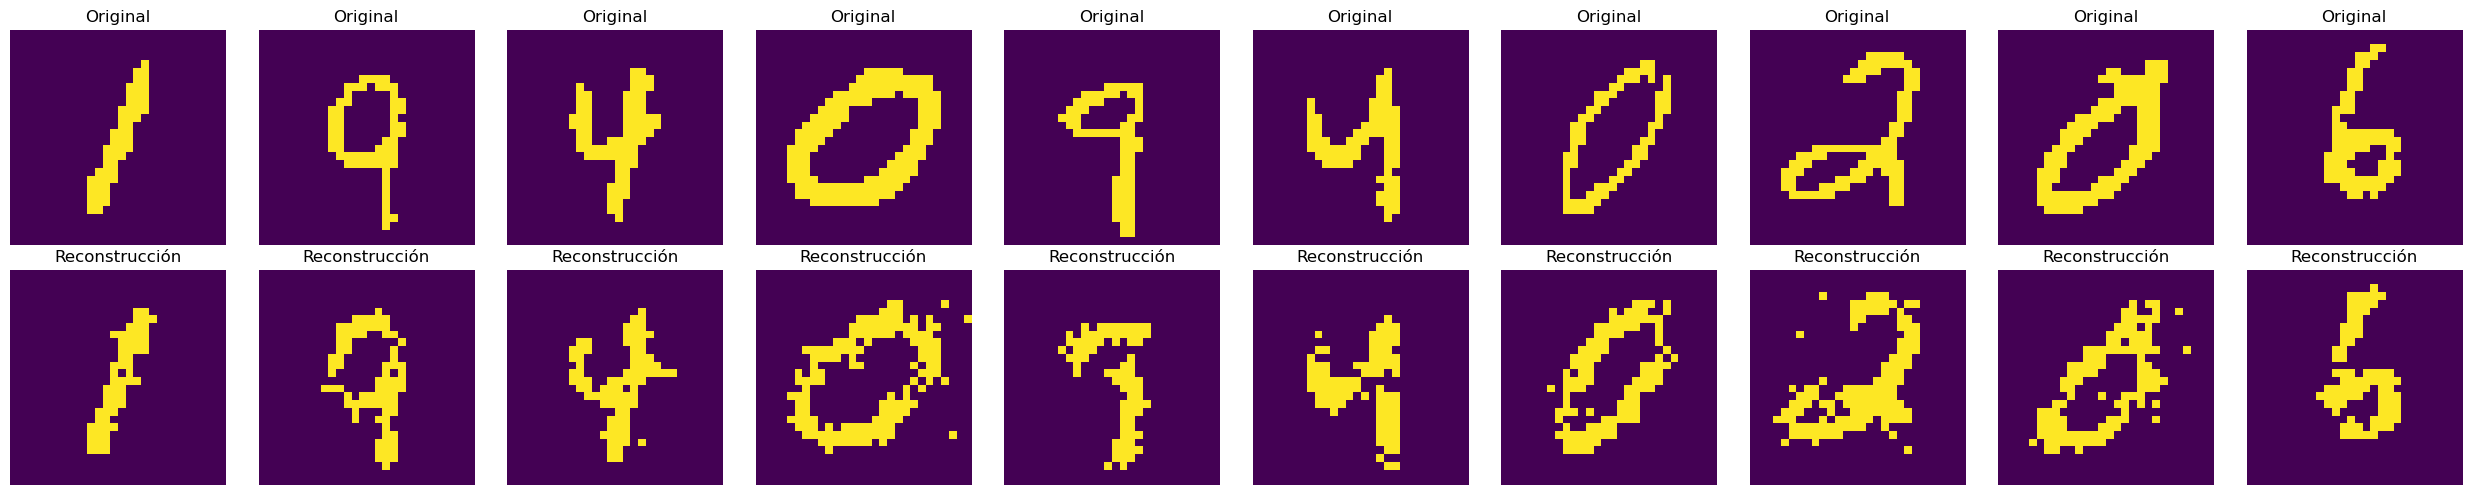

In [14]:
# Mostrar 10 ejemplos de reconstrucciones
plot_reconstructions(rbm, train_loader, device)

In [15]:
save_rbm_weights(rbm, "rbm1_weights.pt")

In [16]:
def transform_data_through_rbm(rbm, data_loader, device):
    transformed_data = []
    with torch.no_grad():  # No necesitamos gradientes aquí
        for batch, _ in data_loader:
            batch = batch.view(batch.size(0), -1).to(device)
            batch = (batch > 0.5).float()
            # Obtener activaciones de la capa oculta
            h_prob, _ = rbm.sample_h(batch)
            transformed_data.append(h_prob)
    return torch.cat(transformed_data, 0)

In [17]:
transformed_dataset = transform_data_through_rbm(rbm, train_loader, device)

transformed_loader = DataLoader(
    TensorDataset(transformed_dataset, torch.zeros(len(transformed_dataset))),
    batch_size=128,
    shuffle=True
)

In [18]:
rbm2 = RBM(n_visible=128, n_hidden=64, device=device)

Visualizando pesos como 8x16


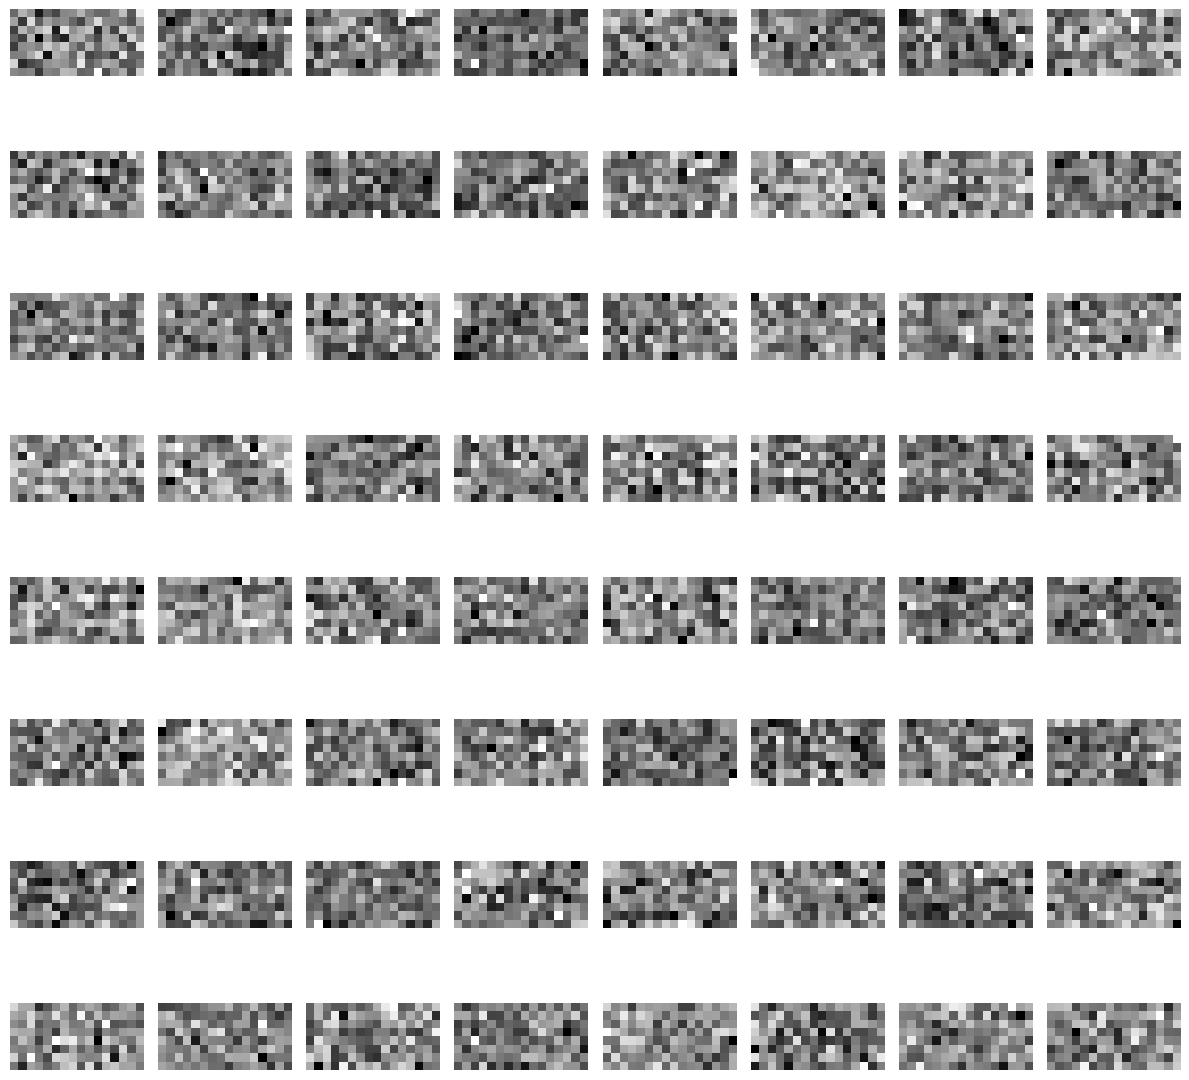

In [19]:
plot_rbm_weights(rbm2)

In [20]:
train_rbm(rbm2, transformed_loader, device, epochs=500, lr=0.005, k=5, binarize=False)

Epoch [1/500] completado.
Epoch [11/500] completado.
Epoch [21/500] completado.
Epoch [31/500] completado.
Epoch [41/500] completado.
Epoch [51/500] completado.
Epoch [61/500] completado.
Epoch [71/500] completado.
Epoch [81/500] completado.
Epoch [91/500] completado.
Epoch [101/500] completado.
Epoch [111/500] completado.
Epoch [121/500] completado.
Epoch [131/500] completado.
Epoch [141/500] completado.
Epoch [151/500] completado.
Epoch [161/500] completado.
Epoch [171/500] completado.
Epoch [181/500] completado.
Epoch [191/500] completado.
Epoch [201/500] completado.
Epoch [211/500] completado.
Epoch [221/500] completado.
Epoch [231/500] completado.
Epoch [241/500] completado.
Epoch [251/500] completado.
Epoch [261/500] completado.
Epoch [271/500] completado.
Epoch [281/500] completado.
Epoch [291/500] completado.
Epoch [301/500] completado.
Epoch [311/500] completado.
Epoch [321/500] completado.
Epoch [331/500] completado.
Epoch [341/500] completado.
Epoch [351/500] completado.
Epo

Visualizando pesos como 8x16


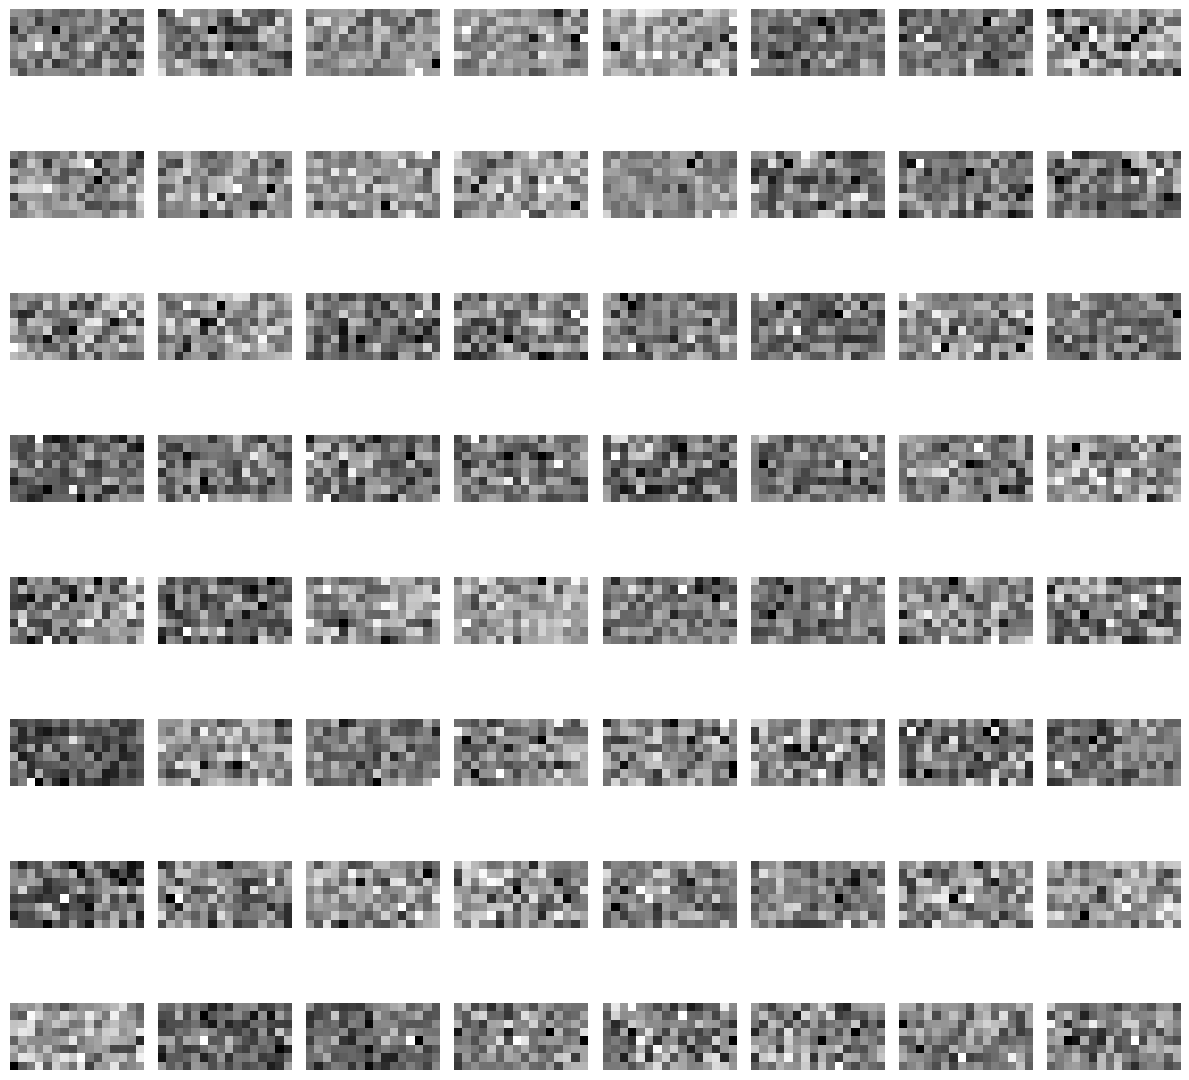

In [21]:
plot_rbm_weights(rbm2)

Visualizando reconstrucciones en forma de 8x16


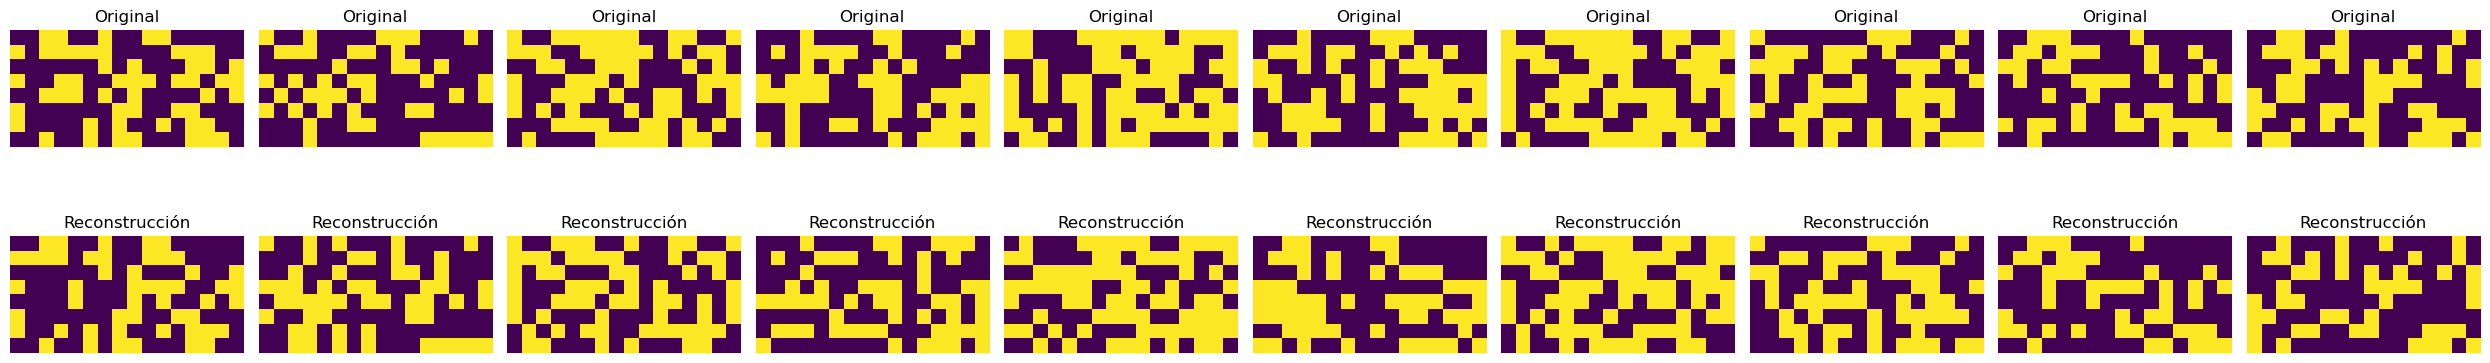

In [22]:
plot_reconstructions(rbm2, transformed_loader, device)

In [23]:
save_rbm_weights(rbm2, "rbm2_weights.pt")

---
### DBN

In [24]:
def extract_features(rbm1, rbm2, data_loader, device):
    features = []
    labels = []
    
    for batch, label in data_loader:
        batch = batch.view(batch.size(0), -1).to(device)
        batch = (batch > 0.5).float()

        # Pasamos los datos por la primera RBM
        h_prob1, _ = rbm1.sample_h(batch)

        # Pasamos la salida de rbm1 a la segunda RBM
        h_prob2, _ = rbm2.sample_h(h_prob1)

        features.append(h_prob2.cpu().detach())
        labels.append(label.cpu())

    return torch.cat(features), torch.cat(labels)

In [25]:
class DBN(nn.Module):
    def __init__(self, rbm1, rbm2, num_classes=10):
        super(DBN, self).__init__()
        self.rbm1 = rbm1
        self.rbm2 = rbm2
        self.classifier = nn.Linear(64, num_classes)  # Capa final para clasificación

    def forward(self, x):
        h_prob1, _ = self.rbm1.sample_h(x)
        h_prob2, _ = self.rbm2.sample_h(h_prob1)
        return self.classifier(h_prob2)

In [26]:
dbn = DBN(rbm, rbm2).to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dbn.classifier.parameters(), lr=0.0005)

/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [64, 128], strides() = [1, 64]
param.sizes() = [64, 128], strides() = [128, 1] (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_19qm5ghvuj/croot/libtorch_1736268753361/work/torch/csrc/autograd/functions/accumulate_grad.h:218.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Loss = 2.1846
Epoch 11: Loss = 0.7350
Epoch 21: Loss = 0.5074
Epoch 31: Loss = 0.4219
Epoch 41: Loss = 0.3807
Epoch 51: Loss = 0.3534
Epoch 61: Loss = 0.3306
Epoch 71: Loss = 0.3175
Epoch 81: Loss = 0.3094
Epoch 91: Loss = 0.3042


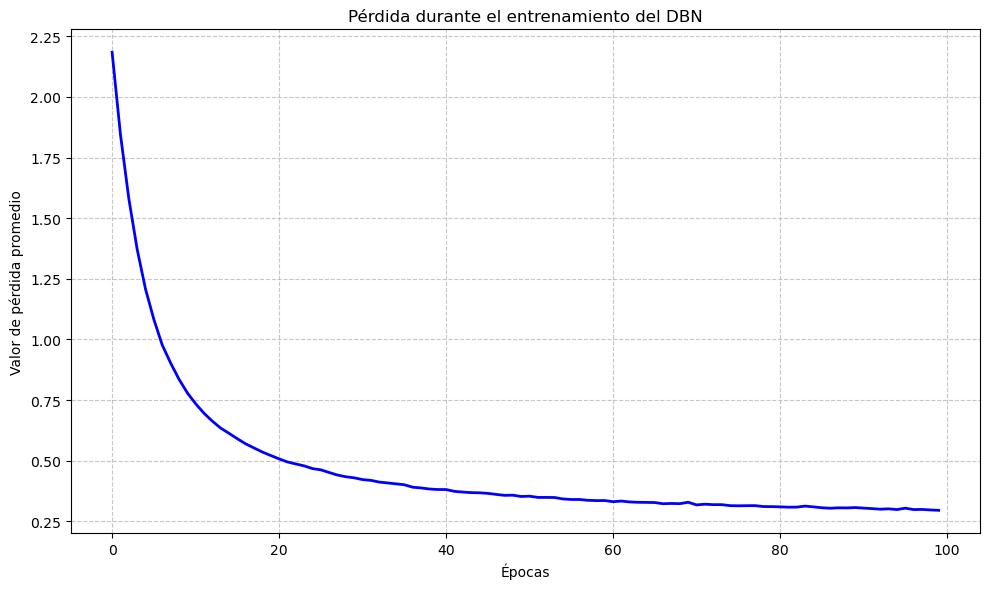

In [28]:
losses = []
for epoch in range(100):
    epoch_loss = 0
    batch_count = 0
    
    for batch, label in train_loader:
        batch, label = batch.to(device), label.to(device)
        batch = (batch > 0.5).float().view(batch.size(0), -1)

        optimizer.zero_grad()
        output = dbn(batch)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    # Calcular la pérdida promedio por época
    avg_loss = epoch_loss / batch_count
    losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(losses, color='blue', linewidth=2)
plt.title('Pérdida durante el entrenamiento del DBN')
plt.xlabel('Épocas')
plt.ylabel('Valor de pérdida promedio')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
# Evaluación del modelo en el conjunto de entrenamiento
dbn.eval()  # Poner el modelo en modo evaluación
correct = 0
total = 0

with torch.no_grad():  # No calculamos gradientes durante la evaluación
    for batch, label in train_loader:
        batch, label = batch.to(device), label.to(device)
        batch = (batch > 0.5).float().view(batch.size(0), -1)
        
        outputs = dbn(batch)
        _, predicted = torch.max(outputs.data, 1)
        
        total += label.size(0)
        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy en el conjunto de entrenamiento: {accuracy:.2f}%')


Accuracy en el conjunto de entrenamiento: 91.13%


In [30]:
# Evaluación del modelo en el conjunto de prueba
dbn.eval()  # Poner el modelo en modo evaluación
correct = 0
total = 0

with torch.no_grad():  # No calculamos gradientes durante la evaluación
    for batch, label in test_loader:
        batch, label = batch.to(device), label.to(device)
        batch = (batch > 0.5).float().view(batch.size(0), -1)
        
        outputs = dbn(batch)
        _, predicted = torch.max(outputs.data, 1)
        
        total += label.size(0)
        correct += (predicted == label).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy en el conjunto de prueba: {test_accuracy:.2f}%')


Accuracy en el conjunto de prueba: 91.08%
